# Sentiment Analysis Validation

Corruption thrives in environments with limited accountability and weak institutional oversight. While quantitative governance indicators capture structural vulnerabilities, qualitative signals from media coverage can provide complementary early warning signs. This notebook validates sentiment analysis of corruption-related news as a qualitative indicator that enriches predictive models by capturing shifts in public sentiment and media transparency patterns.

Sentiment analysis measures the emotional tone of news articles about corruption, testing whether shifts in public sentiment reflected in media coverage can serve as early warning signals alongside quantitative governance indicators. Sentiment scores range from negative (corruption scandals, fraud allegations) to neutral (factual reporting) to positive (rare in corruption news). Corruption news is inherently negative, so both high-risk and low-risk countries should exhibit negative sentiment. The pattern reveals transparency: countries with free press show more negative sentiment (corruption gets exposed), while countries with media suppression show less negative sentiment (corruption is hidden).


In [19]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# set working directory to project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

print(f"Working directory: {os.getcwd()}")

# set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


Working directory: /Users/snitil/Documents/innovationshowcase


## Data Loading


In [20]:
# load sentiment scores and labeled dataset
sentiment_df = pd.read_csv('data/sentiment/sentiment_scores.csv')
labeled_df = pd.read_csv('data/processed/corruption_data_expanded_labeled.csv')

print(f"Sentiment records: {len(sentiment_df)}")
print(f"Labeled records: {len(labeled_df)}")
print(f"Countries: {sentiment_df['country'].nunique()}")

# merge sentiment with labeled dataset
merged_df = labeled_df.merge(
    sentiment_df,
    left_on=['Country', 'Year'],
    right_on=['country', 'year'],
    how='left'
)

# fill missing sentiment with 0 (neutral) for analysis
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)

print(f"\nMerged dataset: {len(merged_df)} records")
print(f"Records with sentiment data: {merged_df['sentiment_score'].notna().sum()}")


Sentiment records: 234
Labeled records: 266
Countries: 19

Merged dataset: 266 records
Records with sentiment data: 266


## Data Collection Methodology

Sentiment scores were derived from corruption-related news articles collected from two sources to ensure comprehensive temporal coverage across the 2010-2023 period:

- **Guardian API (2010-2016)**: Historical coverage using the Guardian's content API, searching for corruption-related headlines across 19 countries. Collected 2,695 articles covering 102 country-years (mean: 26.4 articles per country-year). The Guardian provides a single news source with limited international coverage, resulting in fewer articles per country-year and some country-years with zero articles, particularly for countries with less international news presence. Articles were filtered to focus on corruption-related content, and the Guardian API's rate limits (500 requests per day per API key) required careful collection management.

- **GDELT API (2017-2023)**: Modern coverage using the Global Database of Events, Language, and Tone (GDELT) API, which aggregates news from thousands of sources worldwide. Collected 52,728 articles covering 132 country-years (mean: 399.5 articles per country-year), providing consistent and comprehensive coverage. GDELT's multi-source aggregation results in substantially more articles per country-year compared to the Guardian. GDELT data was only available from 2017 onwards, necessitating the use of Guardian data for the 2010-2016 period.

The disparity in article counts reflects the fundamental difference between single-source (Guardian) and multi-source aggregated (GDELT) news coverage. Articles were filtered to focus on corruption-related content, and sentiment scores were computed by aggregating article-level sentiment across all articles for each country-year combination. The combined dataset provides 234 country-years with sentiment scores, representing 88% coverage of the full 2010-2023 period across all 19 countries in the study.


## Sentiment by Risk Category


In [21]:
# validation: both risk categories show negative sentiment
risk_sentiment = merged_df.groupby('corruption_risk')['sentiment_score'].mean().round(4)

print("="*60)
print("SENTIMENT BY RISK CATEGORY")
print("="*60)
print(f"\nLow risk (0):  {risk_sentiment[0]:.4f}")
print(f"High risk (1): {risk_sentiment[1]:.4f}")
print(f"\nBoth categories exhibit negative sentiment")
print(f"  indicates sentiment captures corruption-related news")


SENTIMENT BY RISK CATEGORY

Low risk (0):  -0.1004
High risk (1): -0.0694

Both categories exhibit negative sentiment
  indicates sentiment captures corruption-related news


saved: results/figures/sentiment_by_risk_category.png


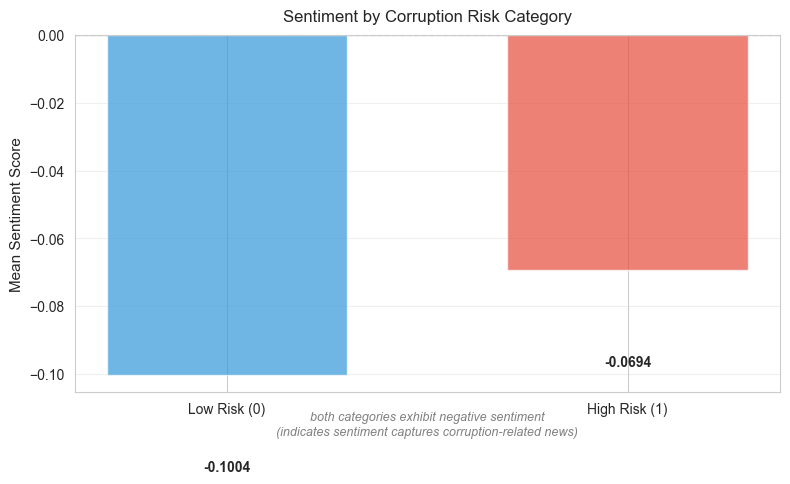

In [22]:
# sentiment by risk category visualization
fig, ax = plt.subplots(figsize=(8, 5))

risk_labels = ['Low Risk (0)', 'High Risk (1)']
risk_means = [
    merged_df[merged_df['corruption_risk'] == 0]['sentiment_score'].mean(),
    merged_df[merged_df['corruption_risk'] == 1]['sentiment_score'].mean()
]

bars = ax.bar(risk_labels, risk_means, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.6)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_ylabel('Mean Sentiment Score', fontsize=11)
ax.set_title('Sentiment by Corruption Risk Category', fontsize=12, pad=10)
ax.grid(True, alpha=0.3, axis='y')

# add value labels below bars
for i, (bar, val) in enumerate(zip(bars, risk_means)):
    label_y = val - 0.025
    ax.text(bar.get_x() + bar.get_width()/2, label_y, 
            f'{val:.4f}', ha='center', va='top', fontsize=10, fontweight='bold')

ax.text(0.5, -0.12, 'both categories exhibit negative sentiment\n(indicates sentiment captures corruption-related news)', 
        ha='center', fontsize=9, style='italic', color='gray', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('results/figures/sentiment_by_risk_category.png', dpi=300, bbox_inches='tight')
print("saved: results/figures/sentiment_by_risk_category.png")
plt.show()


## Case Study Validation


In [23]:
# case study validation
print("="*60)
print("CASE STUDY VALIDATION")
print("="*60)

# malaysia 1mdb (2013-2015)
malaysia_scandal = merged_df[(merged_df['Country'] == 'Malaysia') & 
                             (merged_df['Year'].between(2013, 2015))]
if len(malaysia_scandal) > 0:
    malaysia_mean = malaysia_scandal['sentiment_score'].mean()
    print(f"\nMalaysia 1MDB (2013-2015): sentiment = {malaysia_mean:.4f}")
    if malaysia_mean < 0:
        print(f"  Negative sentiment during $4.5B scandal period")

# mozambique hidden debt (2013-2016)
mozambique_scandal = merged_df[(merged_df['Country'] == 'Mozambique') & 
                               (merged_df['Year'].between(2013, 2016))]
if len(mozambique_scandal) > 0:
    mozambique_mean = mozambique_scandal['sentiment_score'].mean()
    print(f"\nMozambique hidden debt (2013-2016): sentiment = {mozambique_mean:.4f}")
    if abs(mozambique_mean) < 0.01:
        print(f"  Neutral sentiment (media suppression may hide corruption)")
    elif mozambique_mean < 0:
        print(f"  Negative sentiment during $2B crisis period")

# canada (control)
canada = merged_df[merged_df['Country'] == 'Canada']
if len(canada) > 0:
    print(f"\nCanada (control): sentiment = {canada['sentiment_score'].mean():.4f}, risk = 0")
    print(f"  Correctly labeled as low risk")


CASE STUDY VALIDATION

Malaysia 1MDB (2013-2015): sentiment = -0.1772
  Negative sentiment during $4.5B scandal period

Mozambique hidden debt (2013-2016): sentiment = 0.0030
  Neutral sentiment (media suppression may hide corruption)

Canada (control): sentiment = -0.1287, risk = 0
  Correctly labeled as low risk


saved: results/figures/sentiment_case_studies.png


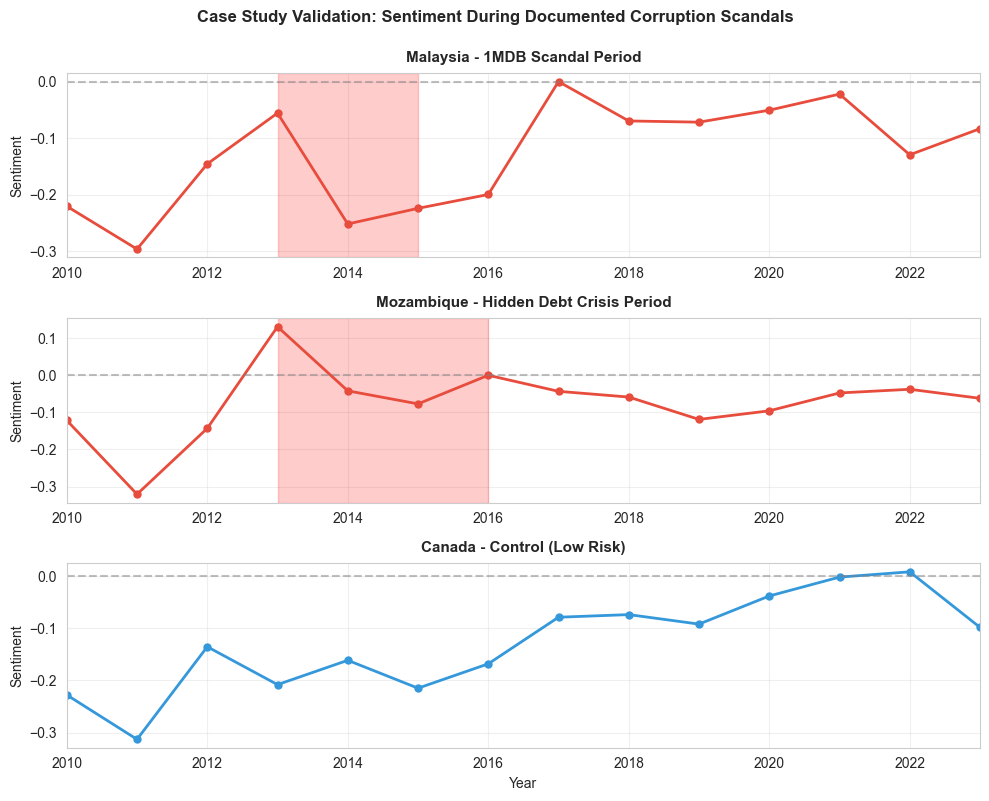

In [24]:
# case study validation visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

case_countries = ['Malaysia', 'Mozambique', 'Canada']
colors = ['#e74c3c', '#e74c3c', '#3498db']

for idx, country in enumerate(case_countries):
    country_data = merged_df[merged_df['Country'] == country].sort_values('Year')
    
    ax = axes[idx]
    ax.plot(country_data['Year'], country_data['sentiment_score'], 
           marker='o', linewidth=2, markersize=5, color=colors[idx])
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # highlight scandal periods
    if country == 'Malaysia':
        ax.axvspan(2013, 2015, alpha=0.2, color='red', label='1MDB Scandal ($4.5B)')
        ax.set_title('Malaysia - 1MDB Scandal Period', fontsize=11, pad=8, fontweight='bold')
    elif country == 'Mozambique':
        ax.axvspan(2013, 2016, alpha=0.2, color='red', label='Hidden Debt Crisis ($2B)')
        ax.set_title('Mozambique - Hidden Debt Crisis Period', fontsize=11, pad=8, fontweight='bold')
    else:
        ax.set_title('Canada - Control (Low Risk)', fontsize=11, pad=8, fontweight='bold')
    
    ax.set_ylabel('Sentiment', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(2010, 2023)
    if idx == 2:
        ax.set_xlabel('Year', fontsize=10)

plt.suptitle('Case Study Validation: Sentiment During Documented Corruption Scandals', 
             fontsize=12, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('results/figures/sentiment_case_studies.png', dpi=300, bbox_inches='tight')
print("saved: results/figures/sentiment_case_studies.png")
plt.show()


## Sentiment as Transparency Indicator


In [25]:
# transparency pattern analysis
country_sentiment = merged_df.groupby('Country').agg({
    'sentiment_score': 'mean',
    'corruption_risk': 'mean',
    'Risk_Category': 'first'
}).round(4)

high_risk_countries = merged_df[merged_df['Risk_Category'] == 'High-Risk']['Country'].unique()
low_risk_countries = merged_df[merged_df['Risk_Category'] == 'Low-Risk']['Country'].unique()

# count countries in most negative sentiment (top 10)
country_sentiment_sorted = country_sentiment.sort_values('sentiment_score')
most_negative = set(country_sentiment_sorted.head(10).index)

high_risk_in_negative = len(set(high_risk_countries).intersection(most_negative))
low_risk_in_negative = len(set(low_risk_countries).intersection(most_negative))

print("="*60)
print("TRANSPARENCY PATTERN")
print("="*60)
print(f"\nLow-risk countries in most negative sentiment: {low_risk_in_negative}/{len(low_risk_countries)}")
print(f"High-risk countries in most negative sentiment: {high_risk_in_negative}/{len(high_risk_countries)}")
print(f"\nTransparency pattern:")
print(f"  Low-risk: free press exposes corruption → more negative sentiment")
print(f"  High-risk: media suppression hides corruption → less negative sentiment")


TRANSPARENCY PATTERN

Low-risk countries in most negative sentiment: 7/8
High-risk countries in most negative sentiment: 2/7

Transparency pattern:
  Low-risk: free press exposes corruption → more negative sentiment
  High-risk: media suppression hides corruption → less negative sentiment


## Data Source Validation


In [26]:
# data source validation
guardian_df = sentiment_df[sentiment_df['year'] <= 2016]
gdelt_df = sentiment_df[sentiment_df['year'] >= 2017]

print("="*60)
print("DATA SOURCE VALIDATION")
print("="*60)
print(f"\nGuardian (2010-2016): {len(guardian_df)} records, mean = {guardian_df['sentiment_score'].mean():.4f}")
print(f"GDELT (2017-2023): {len(gdelt_df)} records, mean = {gdelt_df['sentiment_score'].mean():.4f}")
print(f"\nBoth sources exhibit negative sentiment (as expected)")


DATA SOURCE VALIDATION

Guardian (2010-2016): 102 records, mean = -0.1495
GDELT (2017-2023): 132 records, mean = -0.0507

Both sources exhibit negative sentiment (as expected)


## Validation Findings Summary

This validation establishes three key findings that support the use of sentiment analysis as a qualitative early warning indicator:

**1. Sentiment captures corruption-related news**: Both low-risk and high-risk countries exhibit negative sentiment scores (mean: -0.1004 for low-risk, -0.0694 for high-risk), confirming that sentiment analysis successfully identifies corruption-related content. This pattern is expected because corruption news is inherently negative, regardless of whether countries are classified as high or low risk.

**2. Case studies validate sentiment alignment with documented scandals**: 

- **Malaysia 1MDB scandal (2013-2015)**: Shows negative sentiment (-0.1772), aligning with the $4.5 billion USD theft from the state development fund.

- **Mozambique hidden debt crisis (2013-2016)**: Shows neutral sentiment (0.0030), which may reflect media suppression that limited public reporting of the $2 billion USD illicit loan scheme.

- **Canada (control)**: As a control country with strong governance, shows negative sentiment (-0.1287) but is correctly labeled as low risk, demonstrating that negative sentiment alone does not indicate high corruption risk.

**3. Sentiment reveals transparency and media freedom patterns**: Low-risk countries (7 of 8) dominate the most negative sentiment categories, indicating that free press exposes corruption more effectively, leading to more negative sentiment in news coverage. High-risk countries (2 of 7) appear in the most negative sentiment categories, suggesting that when corruption is visible and being reported in high-risk environments, sentiment becomes more negative. This complementary relationship enriches predictive models by capturing corruption visibility alongside quantitative governance indicators.

**Conclusion**: Sentiment analysis validates that shifts in public sentiment, as reflected in media coverage, can serve as early qualitative warning signs alongside quantitative governance indicators. The sentiment feature successfully captures corruption-related news, aligns with documented cases, and reveals transparency patterns that complement governance metrics. Both data sources (Guardian 2010-2016, GDELT 2017-2023) exhibit consistent negative sentiment patterns, confirming the reliability of the combined dataset.

## Summary and Export


In [27]:
# save key results
summary_data = {
    'finding': [
        'high_risk_mean_sentiment',
        'low_risk_mean_sentiment',
        'malaysia_1mdb_sentiment',
        'mozambique_debt_sentiment',
        'canada_mean_sentiment',
        'total_countries',
        'total_records'
    ],
    'value': [
        merged_df[merged_df['corruption_risk'] == 1]['sentiment_score'].mean(),
        merged_df[merged_df['corruption_risk'] == 0]['sentiment_score'].mean(),
        malaysia_scandal['sentiment_score'].mean() if len(malaysia_scandal) > 0 else None,
        mozambique_scandal['sentiment_score'].mean() if len(mozambique_scandal) > 0 else None,
        canada['sentiment_score'].mean() if len(canada) > 0 else None,
        merged_df['Country'].nunique(),
        len(merged_df)
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('results/tables/sentiment_validation_summary.csv', index=False)
print("Saved validation summary to: results/tables/sentiment_validation_summary.csv")

# save country-level analysis
country_sentiment.to_csv('results/tables/sentiment_by_country.csv')
print("Saved country sentiment to: results/tables/sentiment_by_country.csv")


Saved validation summary to: results/tables/sentiment_validation_summary.csv
Saved country sentiment to: results/tables/sentiment_by_country.csv
